Using TensorFlow backend.


Train matrix shape (60000, 28, 28, 1)
Test matrix shape (10000, 28, 28, 1)
Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Conv2D)             (None, 26, 26, 16)        144       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
layer_2 (Conv2D)             (None, 11, 11, 16)        2304      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
layer_3 (Dense)              

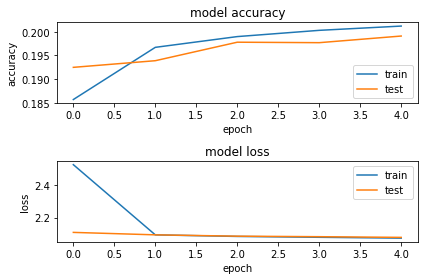

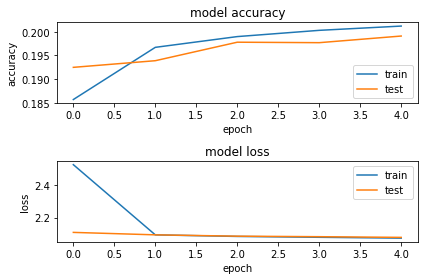

In [1]:
# based on steps in https://www.tensorflow.org/lite/performance/post_training_integer_quant

import tensorflow as tf
import numpy as np
import h5py
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math

from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
import tensorflow.python.keras
# import tensorflow.contrib.keras as keras
from keras.utils import to_categorical

import os

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

img_rows, img_cols = 28, 28
    
#Siapkan matrix training 
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
# print the final input shape ready for training
print("Train matrix shape", x_train.shape)
print("Test matrix shape", x_test.shape)
# one-hot encoding using keras' numpy-related utilities
# one hot encoding = index neuron dengan nilai paling tinggi menjadi hasil klasifikasi
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", y_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu,input_shape=(28,28,1), name='layer_1'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
  tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu, name='layer_2'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
  tf.keras.layers.Flatten(),
    
  tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.relu, name='layer_3'),
  tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.softmax, name='layer_Output'),
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

# training the model and saving metrics in history
history = model.fit(x_train, y_train,
          batch_size=128, epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))


# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [2]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
import pathlib
tflite_models_dir = pathlib.Path("../CNN-VLSI/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

28664

In [3]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
mnist_train, _ = tf.keras.datasets.mnist.load_data()
#mnist_train_reshaped = mnist_train[0].reshape(60000,784)
#images = tf.cast(mnist_train_reshaped.reshape(60000, 28, 28, 1), tf.float32) / 255.0
images = tf.cast(mnist_train[0].reshape(60000, 28, 28, 1), tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

10808